Import all the necessary libraries and turn on using GPU

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50
import matplotlib.pyplot as plt



# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPU, 1 Logical GPU


In [3]:
# Define image properties
img_width, img_height = 150, 150  # Size to which the images will be resized
batch_size = 32  # Batch size for training

# Create image data generators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare iterators for each dataset
train_generator = train_datagen.flow_from_directory(
    '/Users/nazarii_mozol/Downloads/Cats_and_Dogs/train/',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    '/Users/nazarii_mozol/Downloads/Cats_and_Dogs/val/',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Display the mapping of classes
train_generator.class_indices


Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [9]:
# Define the model
model_fc = Sequential()

# Flatten layer to convert the 2D image to a 1D vector
model_fc.add(Flatten(input_shape=(img_width, img_height, 3)))

# First hidden layer with relu activation
model_fc.add(Dense(units=512, activation='relu'))

# Second hidden layer
model_fc.add(Dense(units=256, activation='relu'))

# Third hidden layer
model_fc.add(Dense(units=128, activation='relu'))

# Output layer with a single neuron and sigmoid activation for binary classification
model_fc.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model_fc.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Summarize the model
model_fc.summary()

# Train the model using the training generator and validate with the validation generator
history_fc = model_fc.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # You can change the number of epochs based on how well the model learns
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 67500)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               34560512  
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34724865 (132.46 MB)
Trainable params: 34724865 (132.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10

In [4]:
# Initialize the model
model = Sequential()

# First convolutional layer with pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer with pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the conv layers to feed into the dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history_cnn = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/10


2023-11-19 19:38:16.932325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 65s 101ms/step - loss: 0.7809 - accuracy: 0.5803 - val_loss: 0.6000 - val_accuracy: 0.6851
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.6227 - accuracy: 0.6710 - val_loss: 0.5653 - val_accuracy: 0.7236
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 1.6565 - accuracy: 0.6284 - val_loss: 1.4730 - val_accuracy: 0.5264
Epoch 4/10
625/625 [==============================] - 74s 118ms/step - loss: 1.1821 - accuracy: 0.5681 - val_loss: 0.8364 - val_accuracy: 0.6169
Epoch 5/10
625/625 [==============================] - 69s 110ms/step - loss: 0.8849 - accuracy: 0.6169 - val_loss: 0.7325 - val_accuracy: 0.6798
Epoch 6/10
625/625 [==============================] - 68s 108ms/step - loss: 0.7466 - accuracy: 0.6529 - val_loss: 0.6993 - val_accuracy: 0.6887
Epoch 7/10
625/625 [==============================] - 67s 107ms/step - loss: 0.7422 - accuracy: 0.6707 - val_loss: 0.6380 - val_accuracy: 0.7

In [7]:
# Load the VGG19 model pre-trained on ImageNet data
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers
for layer in vgg19.layers:
    layer.trainable = False

# Add new layers for the cats and dogs classification task
x = Flatten()(vgg19.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# The model we will train
model = Model(inputs=vgg19.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/2
625/625 [==============================] - 197s 313ms/step - loss: 0.5135 - accuracy: 0.8180 - val_loss: 0.3389 - val_accuracy: 0.8632
Epoch 2/2
625/625 [==============================] - 219s 350ms/step - loss: 0.3337 - accuracy: 0.8600 - val_loss: 0.3005 - val_accuracy: 0.8791


In [8]:
# Load the ResNet50 model pre-trained on ImageNet data
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers
for layer in resnet.layers:
    layer.trainable = False

# Add new layers on top of ResNet
x = GlobalAveragePooling2D()(resnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# The model we will train
model = Model(inputs=resnet.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/5
625/625 [==============================] - 75s 116ms/step - loss: 0.6880 - accuracy: 0.5625 - val_loss: 0.6521 - val_accuracy: 0.6242
Epoch 2/5
625/625 [==============================] - 79s 126ms/step - loss: 0.6654 - accuracy: 0.5962 - val_loss: 0.6379 - val_accuracy: 0.6412
Epoch 3/5
625/625 [==============================] - 83s 133ms/step - loss: 0.6538 - accuracy: 0.6120 - val_loss: 0.6222 - val_accuracy: 0.6583
Epoch 4/5
625/625 [==============================] - 85s 136ms/step - loss: 0.6430 - accuracy: 0.6277 - val_loss: 0.6147 - val_accuracy: 0.6696
Epoch 5/5
625/625 [==============================] - 92s 148ms/step - loss: 0.6357 - accuracy: 0.6357 - val_loss: 0.6226 - val_accuracy: 0.6587


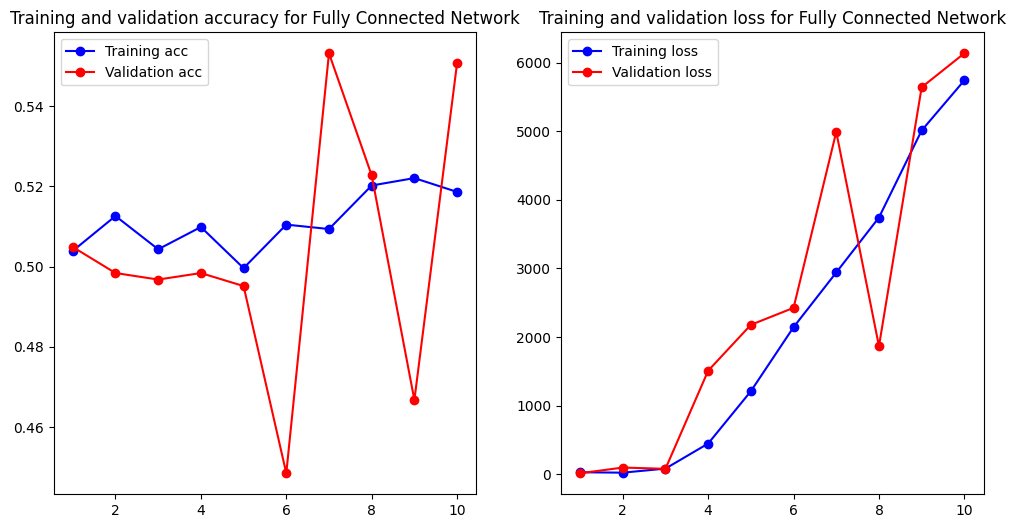

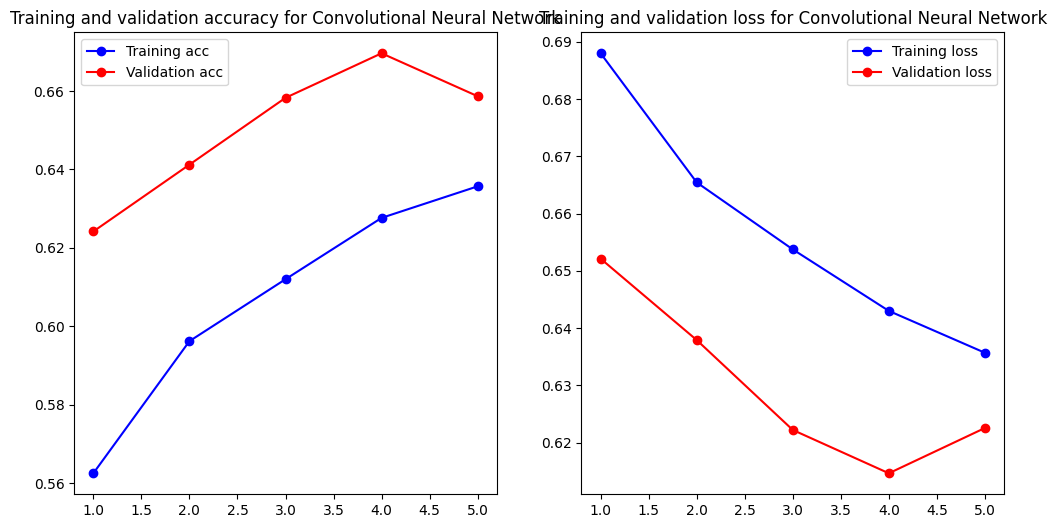

In [11]:
def plot_learning_curves(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training acc')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy for ' + title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title('Training and validation loss for ' + title)
    plt.legend()

    plt.show()

# Plot learning curves for the fully connected network
plot_learning_curves(history_fc, "Fully Connected Network")

# Plot learning curves for the convolutional neural network
plot_learning_curves(history_cnn, "Convolutional Neural Network")
